# Import main libraries

In [509]:
import json
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_json, load_model
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(7)

# Load dataset

In [678]:
df = pd.read_csv("~/clew/train_set.csv")
display(df.head(10))

print("Dataset size", df.shape)

,temporary_index_column,patient_id,timestamp,measurement_x,measurement_y,measurement_z,label
0,1,0,50:34.1,NaN,0.015569,0.068855,1
1,2,0,50:34.1,NaN,0.007757,0.073745,1
2,3,0,50:34.2,NaN,-0.000084,0.073402,1
3,4,0,50:34.2,NaN,-0.007953,0.075000,1
4,5,0,50:34.3,NaN,-0.015851,0.076689,1
5,6,0,50:34.3,0.798000,-0.023776,0.080064,1
6,7,0,50:34.4,0.795484,-0.031727,0.077065,1
7,8,0,50:34.4,0.793049,-0.039704,0.077875,1
8,9,0,50:34.5,0.790697,-0.047705,0.076800,1
9,10,0,50:34.5,0.788426,-0.055730,0.079076,1


Dataset size (799999, 7)


# Handling missing values

In [679]:
df.isna().sum()

temporary_index_column      0
patient_id                  0
timestamp                   0
measurement_x             803
measurement_y             156
measurement_z             145
label                       0
dtype: int64

In [680]:
n = df.shape[0]
df.dropna(axis=0, how='any', inplace=True)
print(f"Removed {n-df.shape[0]} records with timestamp duplicates")

Removed 1104 records with timestamp duplicates


In [681]:
# check for duplications in index
unique_idx = df.temporary_index_column.value_counts().nunique()
if unique_idx > 1:
    print(f"Found duplications in temporary index")
else:
    df.drop(columns="temporary_index_column", inplace=True)

In [682]:
# check for duplications
grouped = df.groupby(["patient_id","timestamp"]).count()
grouped

measurement_x  measurement_y  measurement_z  label
patient_id timestamp                                                    
0          50:34.3                1              1              1      1
           50:34.4                2              2              2      2
           50:34.5                2              2              2      2
           50:34.6                2              2              2      2
           50:34.7                2              2              2      2
...                             ...            ...            ...    ...
25705      40:28.6                2              2              2      2
           40:28.7                2              2              2      2
           40:28.8                2              2              2      2
           40:28.9                2              2              2      2
           40:29.0                3              3              3      3

[403675 rows x 4 columns]

In [683]:
# keep only the last record in case of duplications in patient_id and timestamp
n = df.shape[0]
df.drop_duplicates(subset=["patient_id","timestamp"], keep='last', inplace=True)

print(f"Removed {n-df.shape[0]} records with timestamp duplicates")

Removed 395220 records with timestamp duplicates


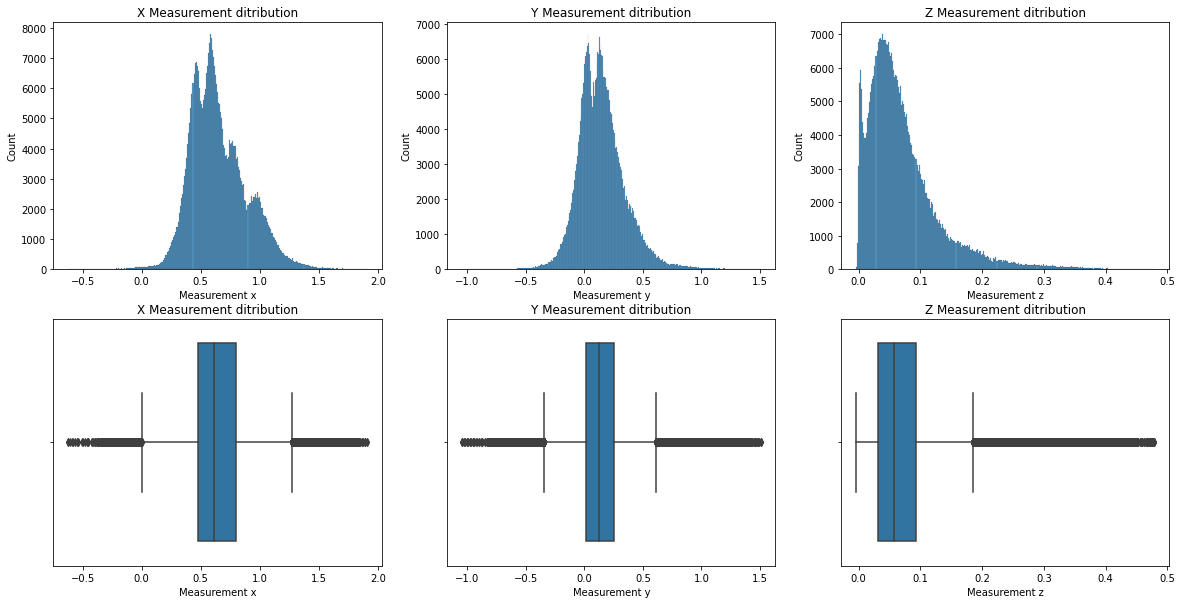

In [684]:
fit, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

sns.histplot(df.measurement_x, ax=axes[0,0])
axes[0,0].set_title("X Measurement ditribution")
axes[0,0].set_xlabel('Measurement x')

sns.histplot(df.measurement_y, ax=axes[0,1])
axes[0,1].set_title("Y Measurement ditribution")
axes[0,1].set_xlabel('Measurement y')

sns.histplot(df.measurement_z, ax=axes[0,2])
axes[0,2].set_title("Z Measurement ditribution")
axes[0,2].set_xlabel('Measurement z')

sns.boxplot(x='measurement_x', data=df, ax=axes[1,0])
axes[1,0].set_title("X Measurement ditribution")
axes[1,0].set_xlabel('Measurement x')

sns.boxplot(x='measurement_y', data=df, ax=axes[1,1])
axes[1,1].set_title("Y Measurement ditribution")
axes[1,1].set_xlabel('Measurement y')

sns.boxplot(x='measurement_z', data=df, ax=axes[1,2])
axes[1,2].set_title("Z Measurement ditribution")
axes[1,2].set_xlabel('Measurement z')

plt.show()

# Remove population outliers using IQR method

In [685]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[(df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))]
    return Q1, Q3, df_final

q1_x, q3_x, x_outlier_removed = remove_outlier_IQR(df.measurement_x)
x_outlier_idx = x_outlier_removed.index
q1_y, q3_y, y_outlier_removed = remove_outlier_IQR(df.measurement_y)
y_outlier_idx = y_outlier_removed.index
q1_z, q3_z, z_outlier_removed = remove_outlier_IQR(df.measurement_z)
z_outlier_idx = z_outlier_removed.index

outlier_removed = np.union1d(x_outlier_idx, y_outlier_idx)
outlier_removed = np.union1d(outlier_removed, z_outlier_idx)

n = df.shape[0]

df.drop(index=outlier_removed, inplace=True)
df.sort_index(axis=0, inplace=True)

print(f"Removed {n-df.shape[0]} suspected population outliers from the dataset.")

Removed 34418 suspected population outliers from the dataset.


# Remove patient-specific outliers using IQR method

In [686]:
outlier_removed = np.array([])
for pat_id in df.patient_id.unique():
    pat_df = df[df.patient_id == pat_id].copy()
    x_outlier_removed = remove_outlier_IQR(pat_df.measurement_x)[-1].index
    y_outlier_removed = remove_outlier_IQR(pat_df.measurement_y)[-1].index
    z_outlier_removed = remove_outlier_IQR(pat_df.measurement_z)[-1].index
    outlier_removed = np.union1d(outlier_removed, x_outlier_removed)
    outlier_removed = np.union1d(outlier_removed, y_outlier_removed)
    outlier_removed = np.union1d(outlier_removed, z_outlier_removed)

n = df.shape[0]
df.drop(index=outlier_removed, inplace=True)
df.sort_index(axis=0, inplace=True)
print(f"Removed {n-df.shape[0]} suspected patient-specific outliers from the dataset.")

Removed 12448 suspected patient-specific outliers from the dataset.


# Define max sequence length

Found 32 different sequence sizes in training set


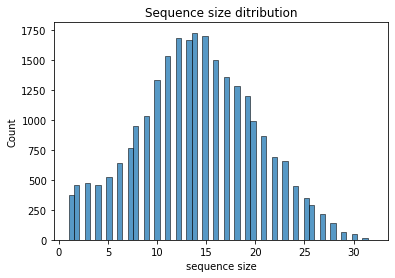

In [687]:
seq_sizes = df.groupby('patient_id').count().label
print(f'Found {len(seq_sizes.unique())} different sequence sizes in training set')

fit, ax = plt.subplots(1,1)
sns.histplot(seq_sizes, ax=ax)
ax.set_title("Sequence size ditribution")
ax.set_xlabel('sequence size')
plt.show()

In [688]:
max_seq_size = 30

# Rescaling the measurements to 0,1 using min-max scaler

In [689]:
scaler = MinMaxScaler()
measurements_label = ['measurement_x','measurement_y','measurement_z']
df[measurements_label] = scaler.fit_transform(df[measurements_label])

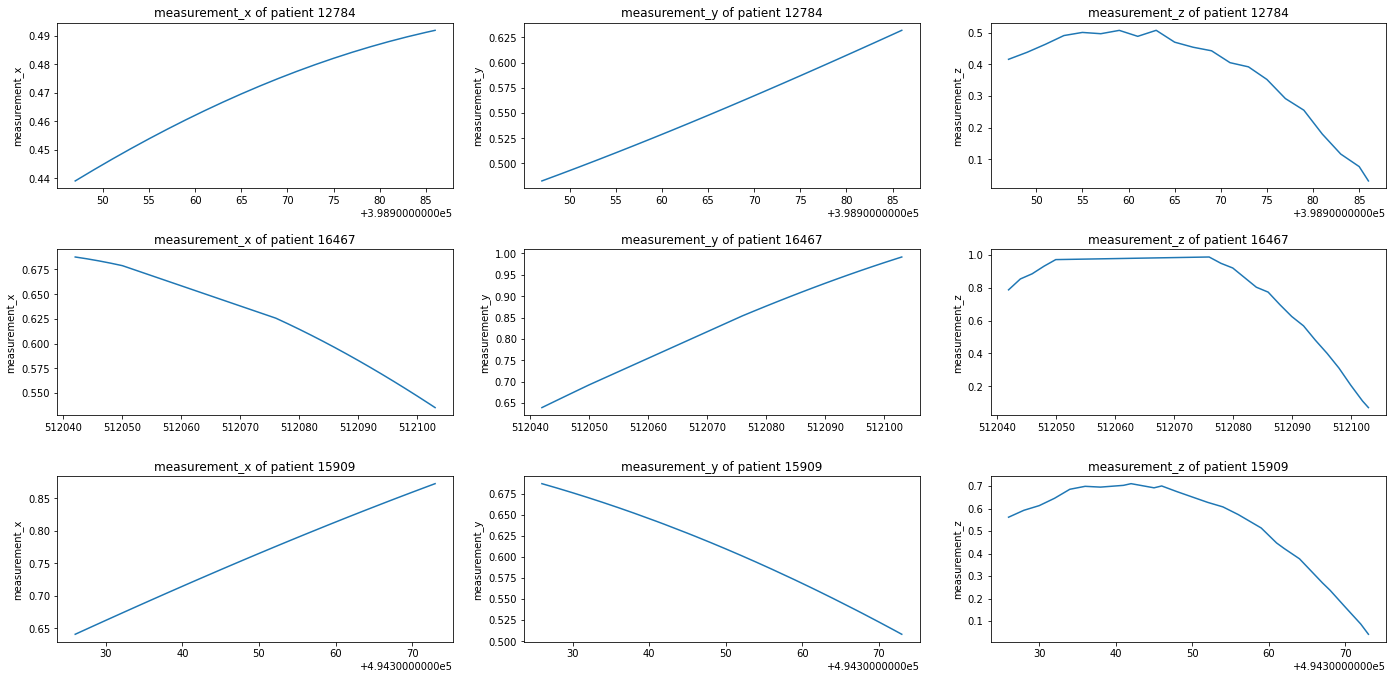

In [690]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
fig.tight_layout(pad=4)

# random patient wih label 0
# labeled_0_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 0, 'patient_id'])]

sns.lineplot(data=labeled_0_pat.measurement_x, ax=axes[0,0])
axes[0,0].set_title(f'measurement_x of patient {int(labeled_0_pat.iloc[0].patient_id)}')

sns.lineplot(data=labeled_0_pat.measurement_y, ax=axes[0,1])
axes[0,1].set_title(f'measurement_y of patient {labeled_0_pat.iloc[0].patient_id}')

sns.lineplot(data=labeled_0_pat.measurement_z, ax=axes[0,2])
axes[0,2].set_title(f'measurement_z of patient {labeled_0_pat.iloc[0].patient_id}')

# random patient wih label 1
# labeled_1_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 1, 'patient_id'])]

sns.lineplot(data=labeled_1_pat.measurement_x, ax=axes[1,0])
axes[1,0].set_title(f'measurement_x of patient {int(labeled_1_pat.iloc[0].patient_id)}')

sns.lineplot(data=labeled_1_pat.measurement_y, ax=axes[1,1])
axes[1,1].set_title(f'measurement_y of patient {labeled_1_pat.iloc[0].patient_id}')

sns.lineplot(data=labeled_1_pat.measurement_z, ax=axes[1,2])
axes[1,2].set_title(f'measurement_z of patient {labeled_1_pat.iloc[0].patient_id}')

# random patient wih label 2
# labeled_2_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 2, 'patient_id'])]

sns.lineplot(data=labeled_2_pat.measurement_x, ax=axes[2,0])
axes[2,0].set_title(f'measurement_x of patient {int(labeled_2_pat.iloc[0].patient_id)}')

sns.lineplot(data=labeled_2_pat.measurement_y, ax=axes[2,1])
axes[2,1].set_title(f'measurement_y of patient {labeled_2_pat.iloc[0].patient_id}')

sns.lineplot(data=labeled_2_pat.measurement_z, ax=axes[2,2])
axes[2,2].set_title(f'measurement_z of patient {labeled_2_pat.iloc[0].patient_id}')

plt.show()

# Feature engineering and zero padding to each measurement

In [771]:
lst = []
for pat in df.patient_id.unique():
    temp_df = df[df.patient_id == pat][measurements_label].copy()
    n = temp_df.shape[0]
    temp_df = np.asarray(temp_df).reshape((1,) + temp_df.shape)
    if n < max_seq_size:
        completion = np.zeros(shape=(1,max_seq_size-n,3))
        temp_df = np.concatenate([completion, temp_df], axis=1)
    else:
        temp_df = temp_df[:,-max_seq_size:,:]
    
    lst.append(temp_df)
    
X = np.concatenate(lst, axis=0)

print("Example of a single record in new processed data:")
print(X[0])

Example of a single record in new processed data:
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.62566528 0.33449261 0.44511634]
 [0.62177869 0.31781874 0.43357527]
 [0.61814993 0.30104186 0.4399062 ]
 [0.61478052 0.28416904 0.42567747]
 [0.61167191 0.26720743 0.40444511]
 [0.60882538 0.25016417 0.39553382]
 [0.60624216 0.23304649 0.36989852]
 [0.60392333 0.21586161 0.33957189]
 [0.60186987 0.1986168  0.3111796 ]
 [0.60008265 0

# Oversample the data with SMOTE

In [772]:
label = df.drop_duplicates(subset='patient_id').label
label.value_counts()

0    17613
1     6214
2     1600
Name: label, dtype: int64

In [775]:
X = X.reshape(X.shape[0], max_seq_size*3)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, label)
X = X_res.reshape((len(X_res),max_seq_size,3))

label = y_res
label.value_counts()

0    17613
1    17613
2    17613
Name: label, dtype: int64

# Train-Validation split

In [776]:
X_train, X_cv, y_train, y_cv = train_test_split(X, label, test_size=0.33, random_state=7)
print('train set size:', X_train.shape)
print('test set size:', X_cv.shape)

train set size: (35402, 30, 3)
test set size: (17437, 30, 3)


# Model Architecture - LSTM

In [785]:
model = Sequential()
model.add(LSTM(max_seq_size))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=5, batch_size=64)
print("\n")
print(model.summary())

Epoch 1/5
554/554 [==============================] - 10s 15ms/step - loss: 0.0000e+00 - acc: 0.4605 - precision_8: 0.8301 - recall_8: 0.8105 - val_loss: 0.0000e+00 - val_acc: 0.5176 - val_precision_8: 0.8988 - val_recall_8: 0.8310
Epoch 2/5
554/554 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - acc: 0.5380 - precision_8: 0.9411 - recall_8: 0.8063 - val_loss: 0.0000e+00 - val_acc: 0.5697 - val_precision_8: 0.9262 - val_recall_8: 0.9265
Epoch 3/5
554/554 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - acc: 0.5562 - precision_8: 0.9526 - recall_8: 0.8320 - val_loss: 0.0000e+00 - val_acc: 0.5095 - val_precision_8: 0.9864 - val_recall_8: 0.6969
Epoch 4/5
554/554 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - acc: 0.5427 - precision_8: 0.9499 - recall_8: 0.8038 - val_loss: 0.0000e+00 - val_acc: 0.5358 - val_precision_8: 0.8710 - val_recall_8: 0.9452
Epoch 5/5
554/554 [==============================] - 8s 14ms/step - loss: 0.000

# Evaluation of the model

## Validation Metrics

In [787]:
loss, accuracy, precision, recall = model.evaluate(X_cv, y_cv, verbose=0)
y_pred = model.predict(X_cv).reshape(-1).astype('int64').tolist()
y_true = y_cv.tolist()

print("\nValidation metrics:")
print({'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall,
       'f1_score': 2*(precision*recall)/(precision + recall)})


Validation metrics:
{'loss': 0.0, 'accuracy': 0.564833402633667, 'precision': 0.9191457033157349, 'recall': 0.9289079308509827, 'f1_score': 0.9240010329057007}


## Confusion Matrix and Classification Report

In [788]:
conf_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=3)
conf_matrix = pd.DataFrame(conf_matrix.numpy(), index=["Actual 0", "Actual 1", "Actual 2"], columns=["Model 0", "Model 1", "Model 2"])

display(conf_matrix)
print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=True))

,Model 0,Model 1,Model 2
Actual 0,4814,948,0
Actual 1,772,5019,0
Actual 2,85,5799,0


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5762
           1       0.43      0.87      0.57      5791
           2       1.00      0.00      0.00      5884

    accuracy                           0.56     17437
   macro avg       0.76      0.57      0.47     17437
weighted avg       0.76      0.56      0.47     17437



# Fitting the scaler and model on the whole training set

In [789]:
model.fit(X, label, epochs=5, batch_size=64)
print("\n")
print(model.summary())

Epoch 1/5
826/826 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.5421 - precision_8: 0.9503 - recall_8: 0.8130
Epoch 2/5
826/826 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.5444 - precision_8: 0.9523 - recall_8: 0.8147
Epoch 3/5
826/826 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.5472 - precision_8: 0.9589 - recall_8: 0.8154
Epoch 4/5
826/826 [==============================] - 9s 11ms/step - loss: 0.0000e+00 - acc: 0.5481 - precision_8: 0.9613 - recall_8: 0.8097
Epoch 5/5
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - acc: 0.5495 - precision_8: 0.9597 - recall_8: 0.8215


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30)                4080      
_________________________________________________________________
dense_8 (De

In [792]:
loss, accuracy, precision, recall = model.evaluate(X, label, verbose=0)
print({'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall,
       'f1_score': 2*(precision*recall)/(precision + recall)})

{'loss': 0.0, 'accuracy': 0.5272999405860901, 'precision': 0.9840629696846008, 'recall': 0.7344574928283691, 'f1_score': 0.8411333321488881}


# Create new labels for new unseen data

In [817]:
# read the test input
test = pd.read_csv("~/clew/test_set.csv").drop(columns=['temporary_index_column'])
# keep last record  in case of timestamp duplicates
test.drop_duplicates(subset=["patient_id","timestamp"], keep='last', inplace=True)
# population outlier removal
iqr_x = q3_x - q1_x
iqr_y = q3_y - q1_y
iqr_z = q3_z - q1_z
x_outlier_removed = test.measurement_x[(test.measurement_x < (q1_x-1.5*iqr_x)) | (test.measurement_x > (q3_x+1.5*iqr_x))]
x_outlier_idx = x_outlier_removed.index
y_outlier_removed = test.measurement_y[(test.measurement_y < (q1_y-1.5*iqr_y)) | (test.measurement_y > (q3_y+1.5*iqr_y))]
y_outlier_idx = y_outlier_removed.index
z_outlier_removed = test.measurement_z[(test.measurement_z < (q1_z-1.5*iqr_z)) | (test.measurement_z > (q3_z+1.5*iqr_z))]
z_outlier_idx = z_outlier_removed.index
outlier_removed = np.union1d(x_outlier_idx, y_outlier_idx)
outlier_removed = np.union1d(outlier_removed, z_outlier_idx)
test.drop(index=outlier_removed, inplace=True)
test.sort_index(axis=0, inplace=True)
# patient-specific outlier removal
outlier_removed = np.array([])
for pat_id in test.patient_id.unique():
    pat_df = test[test.patient_id == pat_id].copy()
    x_outlier_removed = remove_outlier_IQR(pat_df.measurement_x)[-1].index
    y_outlier_removed = remove_outlier_IQR(pat_df.measurement_y)[-1].index
    z_outlier_removed = remove_outlier_IQR(pat_df.measurement_z)[-1].index
    outlier_removed = np.union1d(outlier_removed, x_outlier_removed)
    outlier_removed = np.union1d(outlier_removed, y_outlier_removed)
    outlier_removed = np.union1d(outlier_removed, z_outlier_removed)
test.drop(index=outlier_removed, inplace=True)
test.sort_index(axis=0, inplace=True)
# feature rescaling
test[measurements_label] = scaler.transform(test[measurements_label])

lst = []
for pat in test.patient_id.unique():
    temp_df = test[test.patient_id == pat][measurements_label].copy()
    temp_df = np.asarray(temp_df).reshape((1,) + temp_df.shape)
    n = temp_df.shape[1]
    if n < max_seq_size:
        completion = np.zeros(shape=(1,max_seq_size-n,3))
        temp_df = np.concatenate([completion, temp_df], axis=1)
    else:
        temp_df = temp_df[:,-max_seq_size:,:]
    
    lst.append(temp_df)
    
X_test = np.concatenate(lst, axis=0)

y_pred = model.predict(X_test).reshape(-1).astype('int32')
patients = test.patient_id.drop_duplicates()
res = pd.DataFrame([y_pred, patients], index=["label","patient_id"]).T
res.to_csv('~/clew/submission.csv', index=False)
display(res.head(10))

,label,patient_id
0,0,25705
1,0,25706
2,0,25707
3,0,25708
4,0,25709
5,0,25710
6,0,25711
7,0,25712
8,0,25713
9,0,25714


# Save max_seq_size, population_quantiles, scaler and model to disk

In [816]:
process_params = {
                    "quantiles": {"measurement_x": {"q1": q1_x, "q3": q3_x},
                                "measurement_y": {"q1": q1_y, "q3": q3_y},
                                "measurement_z": {"q1": q1_z, "q3": q3_z}},
                    "max_seq_size": 30
                }

with open("process_params.json", "w") as outFile:
    json.dump(process_params, outFile, indent=4)
    outFile.close()

joblib.dump(scaler, 'scaler.dat')
print("Successfully saved scaler to disk.")
model.save('model.h5')
print("Successfully saved model to disk.")

Successfully saved scaler to disk.
Successfully saved model to disk.
